# Evaluate CausalNNs cases (R2): +0K & +/-4K cases 

This script runs a diagnostic that evaluate the performance of CausalNNs cases (i.e., using test data and R2). Also it evaluates non-linearities in SPCAM (i.e., state fields and physics relationships) by comparing SingleNN and CausalNN with non-linear activation functions (LeakyReLU) vs linear activation functions (linear).

### Statistics

lev, averaged over lat-lon: MSE, TVAR, PVAR, $R^2$, bias

For each 3-D output variable [TPHYSTND, PHQ] the $R^2$ is computed for each level $z$ and then averaged:

$$ R^2_z = 1 - (SSE_z / TVAR_z) $$

where SSE, the sum of squared errors is computed from the predicted values $y$ and the corresponding true values $\hat{y}$:

$$ SSE_z = \frac{1}{nt \times nx \times ny}\sum_{nt}\sum_{nx}\sum_{ny} (y_{t, x, y} - \hat{y}_{t, x, y})^2$$

and the TVAR, the true variance is:

$$ TVAR_Z = \frac{1}{nt \times nx \times ny}\sum_{nt}\sum_{nx}\sum_{ny} (\hat{y}_{t, x, y} - \bar{\hat{y}})^2 $$

with $\bar{\hat{y}}$ being the true mean over $t, x, y$.

## Packages, Modules & Definitions 

In [ ]:
import sys; sys.path.append("..")

import os, pickle, glob
import numpy    as np
import numpy.ma as ma
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.lines import Line2D
import matplotlib as mpl
import matplotlib.transforms as mtransforms
from pathlib import Path

from utils.setup import SetupNeuralNetworks
from utils.setup import SetupDiagnostics
from neural_networks.cbrain.cam_constants  import *
from neural_networks.models import generate_models
from neural_networks.load_models import load_models
from neural_networks.model_diagnostics import ModelDiagnostics
from neural_networks.load_models import get_save_plot_folder


In [2]:
def get_path(setup, base_path=''):
        """ Generate a path based on this model metadata """
        path = Path(base_path)
        str_hl = str(setup.hidden_layers).replace(", ", "_")
        str_hl = str_hl.replace("[", "").replace("]", "")
        path = path / Path(
            "hl_{hidden_layers}-act_{activation}-e_{epochs}/".format(
                hidden_layers=str_hl,
                activation=setup.activation,
                epochs=setup.epochs,
            )
        )
        return path
    
    
def get_dict(pathnm, outFile):

    if os.path.isfile(str(pathnm)+'/'+outFile):
        print(f'{outFile} exists; loading...')
        infile    = open(str(pathnm)+'/'+outFile,'rb')
        eval_dict = pickle.load(infile)
        infile.close()
    else:
        print(f'{outFile} does not exists; create empty dictionary...')
        eval_dict = {}
    
    return eval_dict


def save_dict(eval_dict, pathnm, outFile, verbose=0):
    if verbose > 0:
        print(f"Save dict: {str(pathnm)}/{outFile}")
    outfile = open(str(pathnm)+'/'+outFile,'wb')
    pickle.dump(eval_dict,outfile)
    outfile.close()


# Options

In [18]:
eval_cases  = ['0k', 'm4k', 'p4k']
statsnm     = 'r2' # 'r2'; 'mse'
nTime       = False # 720 # 5855 # False

## Rasp et al. profiles

In [ ]:
# Rasp et al. (2018) - 2021_09_02_TEST_For_Nando.nc (nTime: 5855)
iMod = 'Rasp_etal_2018'
rasp_dict                    = {}
for i, iCase in enumerate(eval_cases):
    if iCase == '0k':
        # 0K
        phq_r2 = np.array([0., 0., 0.021066102885387128, 0.0514988411828482, -0.0025532046540444053,
         0.0005037824261638901, -0.004101913628601128, -0.0012083456230529421,
         0.016112671296461878, 0.10806858679343545, 0.335004027198747,
         0.5976419669149771, 0.7349418726449735, 0.82128715331504, 0.87480042569578,
         0.8810113213671213, 0.8581847682404499, 0.7765646142170176,
         0.6954373528333859, 0.5989878099546596, 0.4994111966358522,
         0.4348499947507394, 0.398625690784006, 0.3240667114284901,
         0.30337542894871594, 0.2833236667380076, 0.2609835973480146,
         0.23945320928486358, 0.2333829588481916, 0.24260476922337704])
        tphystnd_r2 = np.array([0.9922547699495557, 0.9849059136172208, 0.6490321732688649,
         0.6433293556591765, 0.9387710579198724, 0.9107823798258867,
         0.43556987662233315, 0.12746173753175494, 0.18006553574503814,
         0.21777084527374913, 0.304586445796036, 0.3928627442178094,
         0.5064322543677262, 0.6775126802656439, 0.8022394956438594,
         0.8588123153532324, 0.878506896512486, 0.865862758832982, 0.8463927448386868,
         0.8072296961322902, 0.74271532208224, 0.6361502766087155, 0.5110209384335604,
         0.39968810535305266, 0.3532026944004303, 0.3260791555793202,
         0.3250959325837667, 0.35142759375429844, 0.3893123499309805,
         0.38486129174806283])

    elif iCase == 'm4k':
        # -4K
        phq_r2 = np.array([0., 0., 0.004271052870761127, -0.03301561850730028, -0.028421927769762823,
         -0.1402430654519793, -0.09069849684249598, -0.08232323904204408,
         -2.244297521970445, -8.777341448271052, -20.77287657729196,
         -26.646178103213014, -12.054249704981943, -1.2508771792822095,
         0.4606242364092945, 0.6754040229667974, 0.7560350683735281,
         0.7583459582360573, 0.6864902263626846, 0.5664656938972954,
         0.4583334215813758, 0.40555272214715354, 0.37991900211218965,
         0.31743948417933654, 0.2927687220841415, 0.25586979172898716,
         0.2313861199942847, 0.21538439778463891, 0.20586842147945938,
         0.21939766302848274])
        tphystnd_r2 = np.array([0.9846138384680957, 0.9747787877824216, 0.6071514783496705,
         0.5693707273603432, 0.8924924239751224, 0.822917449343803,
         0.5485745003256834, 0.07922142771156027, -0.11590814929047988,
         -0.3070645731558921, -0.6629919822529384, -1.1580453822355365,
         -1.9977986246361708, -0.3245401862586359, 0.4330425369164347,
         0.6242907563088453, 0.743598388727696, 0.7881096658934063,
         0.8041686883664273, 0.7541834933008431, 0.6753828841930078,
         0.5695973829291688, 0.449810134814283, 0.3528116749451363,
         0.31952267174121485, 0.30221901674604923, 0.30515328458085966,
         0.330153748535718, 0.33752441209458706, 0.3036118131457506])

    elif iCase == 'p4k':
        # +4K
        phq_r2 = np.array([0., 0., -0.14848953365038886, -0.3964661026750471, -0.000923662041411033,
         0.001051091683721972, -0.10246765139915648, 0.02137775670996378,
         0.09275702369919825, -0.31718433908886734, -1.7287697678994411,
         -3.0730488051426352, -2.7014942439418004, -1.9310361767375959,
         -1.6480462936367624, -0.8992771901870995, -0.5820693141625248,
         0.00816646979187785, 0.25785187300857937, 0.3180215903530502,
         0.2048862924735112, 0.1885563614630722, 0.17273269465832064,
         0.10671824371636451, -0.0001945870254236315, 0.027968309752408715,
         -0.4211536617251064, -0.8147501173050617, -0.896472416379799,
         -0.7819833468801556])
        tphystnd_r2 = np.array([0.9725187495961443, 0.9442662928377147, 0.4541188670538999,
         0.49135440182681545, 0.6925118875261076, 0.478049936714265,
         -2.4177603333954405, -0.8765731767586391, -1.5116287378213475,
         -11.214991809669689, -5.704142945700809, -7.711013723086726,
         -6.947111946364205, -3.2227979267439517, -1.427856460336192,
         -0.5906135397083003, -0.25557707210257385, 0.15651753620794173,
         0.3964076484193979, 0.3542629762293159, 0.3526194687610602,
         0.29287794327090855, 0.23273867223573408, -0.24511887566871748,
         -0.698475058211786, -0.7276915487941824, -0.38952325769623175,
         -0.02197131797301366, -0.15328742229232017, -0.5591636037236194])
    
    rasp_dict[iCase]                    = {}
    rasp_dict[iCase]['phq']             = {}
    rasp_dict[iCase]['tphystnd']        = {}
    rasp_dict[iCase]['phq']['r2']       = ('r2',phq_r2)
    rasp_dict[iCase]['phq']['lab']      = iMod
    rasp_dict[iCase]['tphystnd']['r2']  = ('r2',tphystnd_r2)
    rasp_dict[iCase]['tphystnd']['lab'] = iMod

## Reference (Rasp et al. architecture): SingleNN & CausalNN Full profiles

In [19]:
def eval_reference(eval_cases, cfg_str, outPath_dict, outFile_dict_str, nTime):
    for i, iCase in enumerate(eval_cases):
    
        print(f'Case: {iCase}')

        argv    = ["-c", f"./{cfg_str}_{iCase}.yml"]
        outFile = f'{outFile_dict_str}-{str(nTime)}.pkl'

        setup  = SetupDiagnostics(argv)
        models = load_models(setup)

        models_type = [[setup.nn_type],["SingleNN","CausalSingleNN"]][setup.nn_type=='all']

        pathnm = get_path(setup, base_path=outPath_dict)
        if not os.path.exists(pathnm): Path(pathnm).mkdir(parents=True, exist_ok=True)
        eval_dict = get_dict(pathnm, outFile)
        if iCase not in eval_dict.keys(): eval_dict[iCase] = {}

        print('')

        for iMod, model_type in enumerate(models_type):
            print(model_type)
            if model_type == 'SingleNN' or 'Rand' in model_type:

                md = ModelDiagnostics(setup = setup, models=models[model_type])

                if model_type not in eval_dict[iCase].keys(): eval_dict[iCase][model_type] = {}
                
                for var in models[model_type].keys():

                    if var.var.value not in eval_dict[iCase][model_type].keys(): 
                        eval_dict[iCase][model_type][var.var.value] = {}
                        stats = ma.masked_equal(ma.array([0.]*len(setup.levels)),0.)
                        eval_dict[iCase][model_type][var.var.value] = {
                            statsnm:(statsnm,stats),
                            'lab':model_type,
                        }
                        save_dict(eval_dict, pathnm, outFile, verbose=1)

                    i_level = var.level_idx if var.level_idx != None else 29
                    if ma.is_masked(eval_dict[iCase][model_type][var.var.value][statsnm][1][i_level]):
                        print(f'evaluate: {var}')

                        md.compute_stats('range', var, nTime=nTime)
                        var_stats = md.mean_stats()[f'hor_{statsnm}'][var.var.value.upper()]
                        stats          = eval_dict[iCase][model_type][var.var.value][statsnm][1]
                        stats[i_level] = var_stats
                        print(f'{stats[i_level]}')
                        eval_dict[iCase][model_type][var.var.value] = {
                                    statsnm:(statsnm,stats), 
                                    'lab':model_type,
                                }

                        # Save to pickle object
                        save_dict(eval_dict, pathnm, outFile)

                        print()

                print('\n \n')


            elif model_type == 'CausalSingleNN':
                for pc_alpha in models[model_type].keys():
                    for threshold in models[model_type][pc_alpha].keys():
                        print(f"pc_alpha-threshold: {pc_alpha}-{threshold}")

                        md = ModelDiagnostics(setup = setup, models=models[model_type][pc_alpha][threshold])

                        c_model_type = f'{model_type}_{pc_alpha}_{threshold}'
                        if c_model_type not in eval_dict[iCase].keys(): eval_dict[iCase][c_model_type] = {}
                        for var in models[model_type][pc_alpha][threshold].keys():

                            if var.var.value not in eval_dict[iCase][c_model_type].keys(): 
                                eval_dict[iCase][c_model_type][var.var.value] = {}
                                stats = ma.masked_equal(ma.array([0.]*len(setup.levels)),0.)
                                eval_dict[iCase][c_model_type][var.var.value] = {
                                    statsnm:(statsnm,stats),
                                    'lab':c_model_type,
                                }
                                save_dict(eval_dict, pathnm, outFile, verbose=1)


                            i_level = var.level_idx if var.level_idx != None else 29
                            if ma.is_masked(eval_dict[iCase][c_model_type][var.var.value][statsnm][1][i_level]):
                                print(f'evaluate: {var}')

                                md.compute_stats('range', var, nTime=nTime)
                                var_stats = md.mean_stats()[f'hor_{statsnm}'][var.var.value.upper()]

                                stats          = eval_dict[iCase][c_model_type][var.var.value][statsnm][1]
                                stats[i_level] = var_stats
                                print(f'{stats[i_level]}')
                                eval_dict[iCase][c_model_type][var.var.value] = {
                                    statsnm:(statsnm,stats),
                                    'lab':c_model_type,
                                }

                                # Save to pickle object
                                save_dict(eval_dict, pathnm, outFile)

                                print()

                        print('\n')

        print('\n')
    
    return eval_dict

In [20]:
# SingleNN (Rasp; act-LeakyReLU)
causalsinglenn_dict = eval_reference(
    eval_cases, 
    'cfg_causalsinglenn_rasp_full-profiles', 
    'result_dicts_reference', 
    'offline_eval_full-profiles_nTime', 
    nTime
)

Case: 0k
Load model: models_causal_links-tb_train-tb/SingleNN/hl_256_256_256_256_256_256_256_256_256-act_LeakyReLU-e_18/1_2_model.h5
Load model: models_causal_links-tb_train-tb/SingleNN/hl_256_256_256_256_256_256_256_256_256-act_LeakyReLU-e_18/1_3_model.h5
Load model: models_causal_links-tb_train-tb/SingleNN/hl_256_256_256_256_256_256_256_256_256-act_LeakyReLU-e_18/1_4_model.h5
Load model: models_causal_links-tb_train-tb/SingleNN/hl_256_256_256_256_256_256_256_256_256-act_LeakyReLU-e_18/1_5_model.h5
Load model: models_causal_links-tb_train-tb/SingleNN/hl_256_256_256_256_256_256_256_256_256-act_LeakyReLU-e_18/1_6_model.h5
Load model: models_causal_links-tb_train-tb/SingleNN/hl_256_256_256_256_256_256_256_256_256-act_LeakyReLU-e_18/1_7_model.h5
Load model: models_causal_links-tb_train-tb/SingleNN/hl_256_256_256_256_256_256_256_256_256-act_LeakyReLU-e_18/1_8_model.h5
Load model: models_causal_links-tb_train-tb/SingleNN/hl_256_256_256_256_256_256_256_256_256-act_LeakyReLU-e_18/1_9_model.h5

In [21]:
# SingleNN (Rasp; act-linear)
singlenn_lin_dict = eval_reference(
    eval_cases, 
    'cfg_singlenn_linear_full-profiles', 
    'result_dicts_singlenn_rasp_linear', 
    'offline_eval_full-profiles_nTime', 
    nTime
)

Case: 0k
Load model: models_causal_links-tb_train-tb/SingleNN/hl_256_256_256_256_256_256_256_256_256-act_linear-e_18/1_2_model.h5
Load model: models_causal_links-tb_train-tb/SingleNN/hl_256_256_256_256_256_256_256_256_256-act_linear-e_18/1_3_model.h5
Load model: models_causal_links-tb_train-tb/SingleNN/hl_256_256_256_256_256_256_256_256_256-act_linear-e_18/1_4_model.h5
Load model: models_causal_links-tb_train-tb/SingleNN/hl_256_256_256_256_256_256_256_256_256-act_linear-e_18/1_5_model.h5
Load model: models_causal_links-tb_train-tb/SingleNN/hl_256_256_256_256_256_256_256_256_256-act_linear-e_18/1_6_model.h5
Load model: models_causal_links-tb_train-tb/SingleNN/hl_256_256_256_256_256_256_256_256_256-act_linear-e_18/1_7_model.h5
Load model: models_causal_links-tb_train-tb/SingleNN/hl_256_256_256_256_256_256_256_256_256-act_linear-e_18/1_8_model.h5
Load model: models_causal_links-tb_train-tb/SingleNN/hl_256_256_256_256_256_256_256_256_256-act_linear-e_18/1_9_model.h5
Load model: models_caus

In [22]:
# RandomSingleNN (Rasp; act-LeakyReLU)
randomsinglenn_dict = eval_reference(
    eval_cases, 
    'cfg_randomsinglenn_rasp_full-profiles', 
    'result_dicts_reference', 
    'offline_eval_full-profiles_nTime', 
    nTime
)

Case: 0k
Load model: models_arch-rasp_thrs-opt-mse6_random/RandomSingleNN/hl_256_256_256_256_256_256_256_256_256-act_LeakyReLU-e_18/1_2_model.h5
Load model: models_arch-rasp_thrs-opt-mse6_random/RandomSingleNN/hl_256_256_256_256_256_256_256_256_256-act_LeakyReLU-e_18/1_3_model.h5
Load model: models_arch-rasp_thrs-opt-mse6_random/RandomSingleNN/hl_256_256_256_256_256_256_256_256_256-act_LeakyReLU-e_18/1_4_model.h5
Load model: models_arch-rasp_thrs-opt-mse6_random/RandomSingleNN/hl_256_256_256_256_256_256_256_256_256-act_LeakyReLU-e_18/1_5_model.h5
Load model: models_arch-rasp_thrs-opt-mse6_random/RandomSingleNN/hl_256_256_256_256_256_256_256_256_256-act_LeakyReLU-e_18/1_6_model.h5
Load model: models_arch-rasp_thrs-opt-mse6_random/RandomSingleNN/hl_256_256_256_256_256_256_256_256_256-act_LeakyReLU-e_18/1_7_model.h5
Load model: models_arch-rasp_thrs-opt-mse6_random/RandomSingleNN/hl_256_256_256_256_256_256_256_256_256-act_LeakyReLU-e_18/1_8_model.h5
Load model: models_arch-rasp_thrs-opt-m

In [23]:
# RandomSingleNN (Rasp; act-LeakyReLU)
randomsingle59nn_dict = eval_reference(
    eval_cases, 
    'cfg_randomsingle59nn_rasp_full-profiles', 
    'result_dicts_randomsingle59nn',
    'offline_eval_full-profiles_nTime', 
    nTime
)

Case: 0k
Load model: models_randon_causal59-numparents/RandomSingleNN/hl_256_256_256_256_256_256_256_256_256-act_LeakyReLU-e_18/1_2_model.h5
Load model: models_randon_causal59-numparents/RandomSingleNN/hl_256_256_256_256_256_256_256_256_256-act_LeakyReLU-e_18/1_3_model.h5
Load model: models_randon_causal59-numparents/RandomSingleNN/hl_256_256_256_256_256_256_256_256_256-act_LeakyReLU-e_18/1_4_model.h5
Load model: models_randon_causal59-numparents/RandomSingleNN/hl_256_256_256_256_256_256_256_256_256-act_LeakyReLU-e_18/1_5_model.h5
Load model: models_randon_causal59-numparents/RandomSingleNN/hl_256_256_256_256_256_256_256_256_256-act_LeakyReLU-e_18/1_6_model.h5
Load model: models_randon_causal59-numparents/RandomSingleNN/hl_256_256_256_256_256_256_256_256_256-act_LeakyReLU-e_18/1_7_model.h5
Load model: models_randon_causal59-numparents/RandomSingleNN/hl_256_256_256_256_256_256_256_256_256-act_LeakyReLU-e_18/1_8_model.h5
Load model: models_randon_causal59-numparents/RandomSingleNN/hl_256

In [24]:
# RandCorrSingleNN (Rasp; act-LeakyReLU)
randcorrsingle59nn_dict = eval_reference(
    eval_cases, 
    'cfg_randcorrsingle59nn_rasp_full-profiles', 
    'result_dicts_randcorrsingle59nn',
    'offline_eval_full-profiles_nTime', 
    nTime
)

Case: 0k
Load model: models_randcorr_causal59-numparents/RandCorrSingleNN/hl_256_256_256_256_256_256_256_256_256-act_LeakyReLU-e_18/1_2_model.h5
Load model: models_randcorr_causal59-numparents/RandCorrSingleNN/hl_256_256_256_256_256_256_256_256_256-act_LeakyReLU-e_18/1_3_model.h5
Load model: models_randcorr_causal59-numparents/RandCorrSingleNN/hl_256_256_256_256_256_256_256_256_256-act_LeakyReLU-e_18/1_4_model.h5
Load model: models_randcorr_causal59-numparents/RandCorrSingleNN/hl_256_256_256_256_256_256_256_256_256-act_LeakyReLU-e_18/1_5_model.h5
Load model: models_randcorr_causal59-numparents/RandCorrSingleNN/hl_256_256_256_256_256_256_256_256_256-act_LeakyReLU-e_18/1_6_model.h5
Load model: models_randcorr_causal59-numparents/RandCorrSingleNN/hl_256_256_256_256_256_256_256_256_256-act_LeakyReLU-e_18/1_7_model.h5
Load model: models_randcorr_causal59-numparents/RandCorrSingleNN/hl_256_256_256_256_256_256_256_256_256-act_LeakyReLU-e_18/1_8_model.h5
Load model: models_randcorr_causal59-nu

### Optimized cases

In [25]:
def eval_optimized(cfg_path, SHE_path, model_types, base_path, cfg_path_model_type=False):

    SHE_dict = {}
    for i, iCase in enumerate(eval_cases):

        print(f'Case: {iCase} \n')
        SHE_dict[iCase] = {}

        outFile = f'offline_SHERPA_full-profiles_nTime-{str(nTime)}.pkl'

        for i, model_type in enumerate(model_types):

            print(f"Process model_type: {model_type}")

            # config files
            if not cfg_path_model_type:
                cfg_type = 'single' if model_type == 'SingleNN' else 'pdf'
                cfg_path_model_type = cfg_path+cfg_type
            cfg_files = glob.glob(cfg_path_model_type+'/*.yml')

            for j, cfg_file in enumerate(cfg_files):
                print(cfg_file)
                argv  = ["-c", cfg_file]
                setup = SetupDiagnostics(argv)
                if iCase == '0k':
                    setup.test_data_folder = './SPCAM_tb_preproc'
                    setup.test_data_fn     = '2021_09_02_TEST_For_Nando.nc'
                else:
                    setup.test_data_folder = './Aqua_Generalization_Test_Sets'
                    if iCase == 'm4k':
                        setup.test_data_fn = '2022_02_07_TEST_For_Nando_m4K.nc'
                    else: 
                        setup.test_data_fn = '2022_02_07_TEST_For_Nando_p4K.nc'
                models = load_models(setup)

                pathnm = get_path(setup, base_path=base_path)
                if not os.path.exists(pathnm): Path(pathnm).mkdir(parents=True, exist_ok=True)

                outFile = f'offline_eval-{statsnm}_nTime-{str(nTime)}.pkl'

                sens_dict = get_dict(pathnm, outFile)
                if iCase not in sens_dict.keys(): sens_dict[iCase] = {}

                if model_type not in SHE_dict[iCase].keys(): SHE_dict[iCase][model_type] = {}
                if model_type not in sens_dict[iCase].keys(): sens_dict[iCase][model_type] = {}

                if model_type == 'SingleNN':

                    md = ModelDiagnostics(setup = setup, models=models[model_type])

                    for var in models[model_type].keys():

                        if var.var.value not in sens_dict[iCase][model_type].keys(): 
                            sens_dict[iCase][model_type][var.var.value] = {}
                            stats = ma.masked_equal(ma.array([0.]*len(setup.levels)),0.)
                            sens_dict[iCase][model_type][var.var.value] = {
                                statsnm:(statsnm,stats),
                                'lab':model_type,
                            }
                        if var.var.value not in SHE_dict[iCase][model_type].keys():
                            SHE_dict[iCase][model_type][var.var.value] = {}
                            stats = ma.masked_equal(ma.array([0.]*len(setup.levels)),0.)
                            SHE_dict[iCase][model_type][var.var.value] = {
                                statsnm:(statsnm,stats),
                                'lab':model_type,
                            }

                        lev    = var.level_idx if var.level_idx != None else 29; levKey = str(lev)
                        if ma.is_masked(sens_dict[iCase][model_type][var.var.value][statsnm][1][lev]):
                            print(f'evaluate: {var}')

                            md.compute_stats('range', var, nTime=nTime)
                            var_stats = md.mean_stats()[f'hor_{statsnm}'][var.var.value.upper()]

                            stats      = sens_dict[iCase][model_type][var.var.value][statsnm][1]
                            stats[lev] = var_stats
                            print(f'{stats[lev]}')
                            sens_dict[iCase][model_type][var.var.value] = {
                                        statsnm:(statsnm,stats), 
                                        'lab':model_type,
                                    }

                            # Save to pickle object
                            save_dict(sens_dict, pathnm, outFile)
                        if ma.is_masked(SHE_dict[iCase][model_type][var.var.value][statsnm][1][lev]):
                            SHE_dict[iCase][model_type][var.var.value][statsnm][1][lev] = \
                            sens_dict[iCase][model_type][var.var.value][statsnm][1][lev]


                else:
                    for pc_alpha in models[model_type].keys():
                        for threshold in models[model_type][pc_alpha].keys():
                            print(f"pc_alpha-threshold: {pc_alpha}-{threshold}")

                            md = ModelDiagnostics(setup = setup, models=models[model_type][pc_alpha][threshold])

                            c_model_type = f'{model_type}_{pc_alpha}_{threshold}'
                            if c_model_type not in SHE_dict[iCase][model_type].keys(): 
                                SHE_dict[iCase][model_type][c_model_type] = {}
                            if c_model_type not in sens_dict[iCase][model_type].keys(): 
                                sens_dict[iCase][model_type][c_model_type] = {}

                            for var in models[model_type][pc_alpha][threshold].keys():

                                if var.var.value not in sens_dict[iCase][model_type][c_model_type].keys(): 
                                    sens_dict[iCase][model_type][c_model_type][var.var.value] = {}
                                    stats = ma.masked_equal(ma.array([0.]*len(setup.levels)),0.)
                                    sens_dict[iCase][model_type][c_model_type][var.var.value] = {
                                        statsnm:(statsnm,stats),
                                        'lab':model_type,
                                    }

                                if var.var.value not in SHE_dict[iCase][model_type][c_model_type].keys(): 
                                    SHE_dict[iCase][model_type][c_model_type][var.var.value] = {}
                                    stats = ma.masked_equal(ma.array([0.]*len(setup.levels)),0.)
                                    SHE_dict[iCase][model_type][c_model_type][var.var.value] = {
                                        statsnm:(statsnm,stats),
                                        'lab':model_type,
                                    }

                                lev    = var.level_idx if var.level_idx != None else 29; levKey = str(lev)
                                # print(var, lev, sens_dict[iCase][model_type][c_model_type][var.var.value][statsnm][1][lev])
                                # if 'tphystnd' in var.var.value and lev == 12:
                                if ma.is_masked(sens_dict[iCase][model_type][c_model_type][var.var.value][statsnm][1][lev]):
                                    print(f'evaluate: {var}')

                                    md.compute_stats('range', var, nTime=nTime)
                                    var_stats = md.mean_stats()[f'hor_{statsnm}'][var.var.value.upper()]

                                    stats      = sens_dict[iCase][model_type][c_model_type][var.var.value][statsnm][1]
                                    stats[lev] = var_stats
                                    print(f'{stats[lev]}')
                                    sens_dict[iCase][model_type][c_model_type][var.var.value] = {
                                                statsnm:(statsnm,stats), 
                                                'lab':model_type,
                                            }

                                    # Save to pickle object
                                    save_dict(sens_dict, pathnm, outFile)

                                if ma.is_masked(SHE_dict[iCase][model_type][c_model_type][var.var.value][statsnm][1][lev]):
                                    SHE_dict[iCase][model_type][c_model_type][var.var.value][statsnm][1][lev] = \
                                    sens_dict[iCase][model_type][c_model_type][var.var.value][statsnm][1][lev]

                print()

            print('\n')

        print('\n')
    
    return SHE_dict
    

In [26]:
# 220628_rasp_etal_2018_thrs-opt-dict/mse6
cfg_path    = './nn_config/220628_rasp_etal_2018_thrs-opt-dict/mse6/'
SHE_path    = f'./models_arch-rasp_thrs-opt-mse6/'
model_types = ['CausalSingleNN']
base_path   = 'result_dicts_arch-rasp_thrs-opt-mse6'
cfg_path_model_type = cfg_path

arch_rasp_thrs_opt_mse6_dict = eval_optimized(cfg_path, SHE_path, model_types, base_path, cfg_path_model_type=cfg_path_model_type)

for i, iK in enumerate(eval_cases):
    arch_rasp_thrs_opt_mse6_dict[iK]['CausalSingleNN']['CausalSingleNN_arch-rasp-topt-mse6'] = \
    arch_rasp_thrs_opt_mse6_dict[iK]['CausalSingleNN'].pop('CausalSingleNN_0.01_optimized')
    
    
# 220628_rasp_etal_2018_thrs-opt-dict/mse6
cfg_path    = './nn_config/220628_rasp_etal_2018_thrs-opt-dict/mse6_act-linear/'
SHE_path    = f'./models_arch-rasp_thrs-opt-mse6/'
model_types = ['CausalSingleNN']
base_path   = 'result_dicts_arch-rasp_thrs-opt-mse6_linear'
cfg_path_model_type = cfg_path

arch_rasp_thrs_opt_mse6_linear_dict = eval_optimized(cfg_path, SHE_path, model_types, base_path, cfg_path_model_type=cfg_path_model_type)

for i, iK in enumerate(eval_cases):
    arch_rasp_thrs_opt_mse6_linear_dict[iK]['CausalSingleNN']['CausalSingleNN_arch-rasp-topt-mse6_linear'] = \
    arch_rasp_thrs_opt_mse6_linear_dict[iK]['CausalSingleNN'].pop('CausalSingleNN_0.01_optimized')


Case: 0k 

Process model_type: CausalSingleNN
./nn_config/220628_rasp_etal_2018_thrs-opt-dict/mse6/cfg_NN_Creation_rasp_parcorr_thrs-opt-dict_phq-tphystnd_19.yml
Load model: models_arch-rasp_thrs-opt-mse6/CausalSingleNN/a0.01-toptimized-latwts/hl_256_256_256_256_256_256_256_256_256-act_LeakyReLU-e_18/1_19_model.h5
Load model: models_arch-rasp_thrs-opt-mse6/CausalSingleNN/a0.01-toptimized-latwts/hl_256_256_256_256_256_256_256_256_256-act_LeakyReLU-e_18/0_19_model.h5
offline_eval-r2_nTime-False.pkl exists; loading...
pc_alpha-threshold: 0.01-optimized

./nn_config/220628_rasp_etal_2018_thrs-opt-dict/mse6/cfg_NN_Creation_rasp_parcorr_thrs-opt-dict_2Ds.yml
Load model: models_arch-rasp_thrs-opt-mse6/CausalSingleNN/a0.01-toptimized-latwts/hl_256_256_256_256_256_256_256_256_256-act_LeakyReLU-e_18/2_0_model.h5
Load model: models_arch-rasp_thrs-opt-mse6/CausalSingleNN/a0.01-toptimized-latwts/hl_256_256_256_256_256_256_256_256_256-act_LeakyReLU-e_18/3_0_model.h5
Load model: models_arch-rasp_thrs

In [27]:
## Merge dicts

# Non-linear dicts
ref_dict = {}
for i, iK in enumerate(eval_cases):
    ref_dict[iK] = {}
    
    ref_dict[iK]['SingleNN'] = causalsinglenn_dict[iK]['SingleNN']
    
    # ref_dict[iK]['RandomSingleNN'] = randomsinglenn_dict[iK]['RandomSingleNN']
    
    ref_dict[iK]['RandomSingle59NN'] = randomsingle59nn_dict[iK]['RandomSingleNN']
    
    ref_dict[iK]['RandCorrSingle59NN'] = randcorrsingle59nn_dict[iK]['RandCorrSingleNN']
    
    ref_dict[iK]['CausalSingleNN_0.01_0.59'] = causalsinglenn_dict[iK]['CausalSingleNN_0.01_0.59']
    
    ref_dict[iK]['CausalSingleNN_arch-rasp-topt-mse6'] = arch_rasp_thrs_opt_mse6_dict[iK]['CausalSingleNN']['CausalSingleNN_arch-rasp-topt-mse6']


# Linear dicts
sens_dict = {}
for i, iK in enumerate(eval_cases):
    sens_dict[iK] = {}
    
    sens_dict[iK]['SingleNN_linear'] = singlenn_lin_dict[iK]['SingleNN']
    
    sens_dict[iK]['CausalSingleNN'] = {}
    sens_dict[iK]['CausalSingleNN']['CausalSingleNN_arch-rasp-topt-mse6_linear']     = arch_rasp_thrs_opt_mse6_linear_dict[iK]['CausalSingleNN']['CausalSingleNN_arch-rasp-topt-mse6_linear']

# Profile plots

In [28]:
# adapted from neural_networks.model_diagnostics import plot_profiles
def plot_profiles(
    case,
    spcam_outputs,
    eval_dict,
    eval_keys=False,
    sens_dict=False,
    sens_keys=False,
    rasp_dict=False,
    style='scatter',
    decplc=2,
    title='', 
    save=False,
    savenm=False,
    **kwargs
):

    case_labs_dict = {
        'SingleNN':'Non-causalNN',
        'SingleNN_linear':'Linear Non-causalNN',
        'RandomSingleNN':'Randomly-informedNN',
        'RandomSingle59NN':'Randomly-informed$_{0.59}$NN',
        'RandCorrSingle59NN':'Correlationally-informed$_{0.59}$NN',
        'CausalSingleNN_0.01_0.59':'Causally-informed$_{0.59}$NN',
        'CausalSingleNN_arch-rasp-topt-mse6':'Causally-informedNN',
        'CausalSingleNN_arch-rasp-topt-mse6_linear':'Linear Causally-informedNN',
    }
    
    vars_labs_dict = {
        # 'tphystnd':'dT/dt',r'$\Delta$x,y'
        # 'phq':'dq/dt',
        'tphystnd':r'$\Delta$T$\mathregular{_{phy}}$',
        'phq':'$\Delta$q$\mathregular{_{phy}}$',
    }
    
    metrics_labs_dict = {
        'r2':'R\u00b2',
        'mse':'MSE',
    }
    
    climate_labs = {'0k':'0 K', 'm4k':"\N{MINUS SIGN}4 K", 'p4k':"\N{PLUS SIGN}4 K"}
    
    eval_keys = eval_dict.keys() if not eval_keys else eval_keys
    # sens_keys = sens_dict.keys() if not sens_keys else sens_keys

    mpl.rcParams['font.size']      = 15
    
    n_cols = len(spcam_outputs)
    fig, ax = plt.subplots(1, n_cols, figsize=(12, 5), sharey=True)
    # for axis in ax:
    #     trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
    #     axis.text(0.0, 1.0, 'Hello', transform=axis.transAxes + trans,
    #             fontsize='medium', verticalalignment='top', fontfamily='serif',
    #             bbox=dict(facecolor='none', edgecolor='none', pad=3.0))
    trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
    ax[0].text(0.09, 1., climate_labs[case], transform=ax[0].transAxes + trans,
            fontsize='medium', verticalalignment='top', fontfamily='serif',
            bbox=dict(facecolor='none', edgecolor='none', pad=3.0),fontweight='normal')
    ax[1].text(1.28, 1., climate_labs[case], transform=ax[0].transAxes + trans,
            fontsize='medium', verticalalignment='top', fontfamily='serif',
            bbox=dict(facecolor='none', edgecolor='none', pad=3.0),fontweight='normal')

    colors_dict = {
        'SingleNN':'#494fc1',
        'CausalSingleNN':'#fd084a',
        'RandomSingleNN':'k',
        'RandomSingle59NN':'k',
        'RandCorrSingle59NN':'k',
    }
    linestyles_dict = {
        'SingleNN':'-', 
        'CausalSingleNN_arch-rasp-topt-mse6':'-',
        'CausalSingleNN_0.01_0.59':'--',
        'RandomSingleNN':'-',
        'RandomSingle59NN':':',
        'RandCorrSingle59NN':'--',
    }
    markers = ['x','o','*','+','x','v','^','<','>','1','2','3','4','8','s','p','h','D']
    linestyles = ['--',':']
    
    # Reference
    colors = ['#494fc1','#fd084a','grey','#ff7f0e']
    for i, iVar in enumerate(spcam_outputs):
        
        # Rasp et al. (2018)
        if rasp_dict:
            stats = ma.round(rasp_dict[iVar][statsnm][1],decplc)
            ax[i].plot(
                stats,
                P,
                label=rasp_dict[iVar]['lab'],
                alpha=1.,
                color='grey',
                linestyle='-',
#                 marker=['','.'][style=='scatter'],
                linewidth=4.,
                **kwargs
            )
        
        for j, jMod in enumerate(eval_keys):
            stats = ma.round(eval_dict[jMod][iVar][statsnm][1],decplc)
            ax[i].plot(
                stats,
                P[:len(eval_dict[jMod][iVar][statsnm][1])],
                # label=eval_dict[jMod][iVar]['lab']+' (Rasp et al.)',
                label=case_labs_dict[jMod],
                alpha=.8,
                # color=colors[j],
                color=colors_dict[jMod.split('_')[0]],
                # linestyle='-',
                # linestyle=linestyles_dict[jMod.split('_')[0]][j],
                linestyle=linestyles_dict[jMod],
#                 marker=['','.'][style=='scatter'],
                linewidth=[4.,1.]['Rand' in jMod],
                **kwargs
            )
            
            if j == 0:
                ax[i].vlines(
                    0, P[:len(eval_dict[jMod][iVar][statsnm][1])][0], 
                    P[:len(eval_dict[jMod][iVar][statsnm][1])][-1], 
                    colors='k', 
                    linestyles='--',
                )
                ax[i].set_ylim(
                    P[:len(eval_dict[jMod][iVar][statsnm][1])][0]+10, 
                    P[:len(eval_dict[jMod][iVar][statsnm][1])][-1]+10
                )
                ax[i].invert_yaxis()
                if case == '0k':
                    ax[i].set_xlim(-.02, 1.)
                elif case == 'm4k':
                    ax[i].set_xlim(-.02, 1.)
                else:
                    ax[i].set_xlim(-.02, 1.)
                # ax[i].set_xlabel(f'{iVar} ({eval_dict[jMod][iVar][statsnm][0]})')
                ax[i].set_xlabel(f'{vars_labs_dict[iVar]} ({metrics_labs_dict[statsnm]})')
                if i==0: ax[i].set_ylabel('Pressure (hPa)')
    
    # Sensitivities
    #     markers = [iKey for iKey in Line2D.markers.keys()]
    for i, iVar in enumerate(spcam_outputs):
        # if i==1: ax[i].set_yticklabels('')
        # SHERPA best case: SingleNN
        if sens_keys and 'SingleNN' in model_types:
            single_sens_keys = [s for s in sens_keys if 'SingleNN' in s and 'Causal' not in s]
            for k, kMod in enumerate(single_sens_keys):
                stats = ma.round(sens_dict[kMod][iVar][statsnm][-1],decplc)
                ax[i].plot(
                    stats,
                    P,
                    alpha=.8,
                    color=colors_dict['SingleNN'],
                    linestyle='-',
                    # linestyle=linestyles[k],
    #                 marker=['',markers[0]][style=='scatter'],
                    label=case_labs_dict[kMod],
                )
                
        # SHERPA best case: CausalSingleNN
        if sens_keys:
            if 'CausalSingleNN' in model_types:
                # if not sens_keys:
                #     causal_sens_keys = sens_dict[case]['CausalSingleNN'].keys()
                # if 'SingleNN' in sens_keys:
                #     causal_sens_keys = [iK for iK in sens_keys if iK != 'SingleNN']
                # else:
                #     causal_sens_keys = sens_keys
                causal_sens_keys = [s for s in sens_keys if 'Causal' in s]
                for k, kMod in enumerate(causal_sens_keys):
                    stats = ma.round(sens_dict['CausalSingleNN'][kMod][iVar][statsnm][-1],decplc)
                    ax[i].plot(
                        stats,
                        P,
                        alpha=.8,
                        color=colors_dict['CausalSingleNN'],
                        linestyle='-',
                        # linestyle=linestyles[k],
                        # marker=['',markers[k+1]][style=='scatter'],
                        label=case_labs_dict[kMod],
                    )
        
#         if i==1: ax[i].legend(ncol=2,fontsize='medium',bbox_to_anchor=(-.15, -.4), loc='lower center')
        # if i==1: ax[i].legend(ncol=1,fontsize='x-small',loc=0)
        if i==1: ax[i].legend(bbox_to_anchor=(.24, -.2), fontsize=11)
        
    fig.suptitle(title)
    if save is not False: 
        savenm = 'r2_key-levels.png' if not savenm else savenm
        Path(save).mkdir(parents=True, exist_ok=True)
        fig.savefig(f"{save}/{savenm}",dpi=3000.,bbox_inches='tight')
        print(f"{save}/{savenm}")
    plt.show()

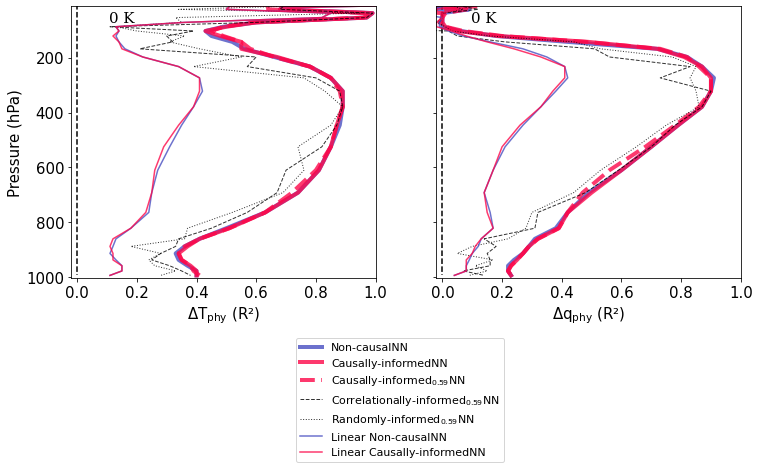

In [36]:
# Plot profile
case='0k' # '0k'; 'm4k'; 'p4k'
decplc=2
outputs = ['tphystnd','phq']
model_types = ['SingleNN','CausalSingleNN']
plot_profiles(
    case,
    outputs,
    
    ref_dict[case],
    # eval_keys=['SingleNN','CausalSingleNN_arch-rasp-topt-mse6','CausalSingleNN_0.01_0.59'],
    # eval_keys=['SingleNN','CausalSingleNN_arch-rasp-topt-mse6','CausalSingleNN_0.01_0.59','RandomSingleNN'],
    eval_keys=['SingleNN','CausalSingleNN_arch-rasp-topt-mse6','CausalSingleNN_0.01_0.59','RandCorrSingle59NN','RandomSingle59NN'],

    sens_dict=sens_dict[case], sens_keys=['SingleNN_linear','CausalSingleNN_arch-rasp-topt-mse6_linear'],

    # rasp_dict=rasp_dict[case],
    style='scatter', # 'scatter'; 'line'
    decplc=decplc,
    title='',

    # save='./plots',
    # savenm=f'r2_Carch-rasp-t0.59_Carch-rasp-toptmse6_full-levels_{case}.png',
    # savenm=f'r2_Carch-rasp-t0.59_Carch-rasp-toptmse6_Rarch-rasp-toptmse6_full-levels_{case}.png',
    # savenm=f'r2_Carch-rasp-t0.59_Carch-rasp-toptmse6_Random0.59_Corr0.59_full-levels_{case}.png',
        
    # linewidth=4.
)